In [2]:
import xarray as xr
from glob import glob
from os import path
import os
import numpy as np

# Create list of CCMP filenames

In [3]:
dir_pattern = 'F:/data/sat_data/ccmp/v02.0/'
dir_pattern_zarr = 'F:/data/sat_data/ccmp/zarr2/'
pattern = 'F:/data/sat_data/ccmp/v02.0/*/*/*_V02.0_L3.0_RSS.nc'

In [4]:
files = [x for x in glob(pattern)]
print(files[0])
print(files[-1])

F:/data/sat_data/ccmp/v02.0\Y1987\M07\CCMP_Wind_Analysis_19870710_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0\Y2020\M08\CCMP_RT_Wind_Analysis_20200819_V02.0_L3.0_RSS.nc


In [5]:
%%time
#list files
files = [x for x in glob(pattern)]
#open dataset
ds=xr.open_mfdataset(files,combine='nested',concat_dim='time',decode_cf=False,mask_and_scale=False)
# if you don't need all the variables, drop extra ones here
# ds = ds.drop({'nobs'})
ds.close()

Wall time: 9min 20s


In [6]:
#remove any duplicates -- CCMP has both NRT and RT data so some files are duplicates -- 
# this returns 1st occurance check this is what you want
_, index = np.unique(ds['time'], return_index=True)
ds = ds.isel(time=index)

# Set Chunk Size Here

In [7]:
#rechunck data      #cci SUGGESTION
itime_chunk = 2000   #200
ilat_chunk = 157    #300
ilon_chunk = 180    #600

ds = ds.chunk({'time':itime_chunk,'latitude':ilat_chunk,'longitude':ilon_chunk})


# Subset & write out zarr store - subset only needed for this test run

In [55]:
%%time
#test this chunck size by subsetting data and checking both time to write and filesize
subset = ds.isel(time=slice(0,itime_chunk),latitude=slice(0,ilat_chunk),longitude=slice(0,ilon_chunk))
#output test zarr data
subset.to_zarr(dir_pattern_zarr, consolidated=True)

Elapsed time to write file was 127.753 seconds


# Check file size - if to small/big adjust cell above & try again

In [56]:
#list files and check size
for var in subset:
    varname = var  #this just gets last var in file, you can set value if you already know eg. 'uwnd' 
files = [x for x in glob(dir_pattern_zarr+str(varname)+'/0*')]
print('testing file:',files[0])
file_size=os.stat(files[0]).st_size/1e6
print('The Zarr chunck is '+'%.0f' % sz+' mb')
print('you want 100-300 mb per file')

testing file: F:/data/sat_data/ccmp/zarr_test/nobs\0.0.0
The Zarr chunck is 90 mb
you want 100-300 mb per file


# Okay you have right chunk size set, now write the entire file
# first delete all files in the zarr directory

In [8]:
%%time
#only need to run once to write data
ds.to_zarr(dir_pattern_zarr, consolidated=True)

Wall time: 3h 32min 19s


# Test reading zarr file and making some plots

Wall time: 3min 21s


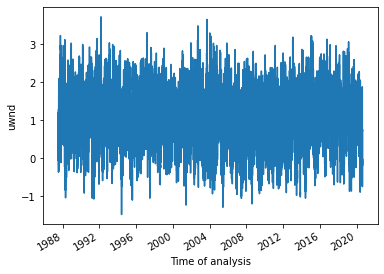

In [35]:
%%time
dir_pattern_zarr = 'F:/data/sat_data/ccmp/zarr2/'
ds2= xr.open_zarr(dir_pattern_zarr)
ts = ds2.uwnd.sel(latitude=slice(-60,0),longitude=slice(70,180)).mean({'latitude','longitude'}).plot()


Wall time: 4min 8s


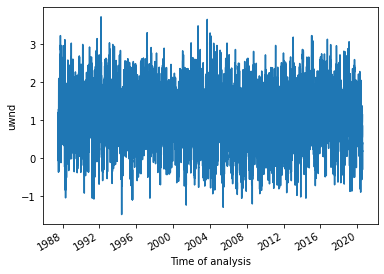

In [36]:
%%time
dir_pattern_zarr = 'F:/data/sat_data/ccmp/zarr/'
ds2= xr.open_zarr(dir_pattern_zarr)
ts = ds2.uwnd.sel(latitude=slice(-60,0),longitude=slice(70,180)).mean({'latitude','longitude'}).plot()


In [19]:
dir_pattern_zarr = 'F:/data/sat_data/ccmp/zarr2/'
ds2= xr.open_zarr(dir_pattern_zarr)
ds2

,Array,Chunk
Bytes,174.09 GB,226.08 MB
Shape,"(48128, 628, 1440)","(2000, 157, 180)"
Count,801 Tasks,800 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,174.09 GB,226.08 MB
Shape,"(48128, 628, 1440)","(2000, 157, 180)"
Count,801 Tasks,800 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


# create CMC SST zarr data files

In [9]:
dir_pattern_zarr = 'F:/data/sst/cmc/zarr/'
dir_pattern = 'F:/data/sst/cmc/CMC0.2deg/v2/'
pattern = 'F:/data/sst/cmc/CMC0.2deg/v2/data/*/*/*-v02.0-fv02.0.nc'
files = [x for x in glob(pattern)]
dir_pattern = 'F:/data/sst/cmc/CMC0.1deg/v3/'
pattern = 'F:/data/sst/cmc/CMC0.1deg/v3/*/*/*-v02.0-fv03.0.nc'
files2 = [x for x in glob(pattern)]

In [10]:
%%time
#open dataset
ds=xr.open_mfdataset(files,combine='nested',concat_dim='time',decode_cf=False,mask_and_scale=False)
ds.close()
ds2=xr.open_mfdataset(files2,combine='nested',concat_dim='time',decode_cf=False,mask_and_scale=False)
ds2.close()

Elapsed time was 1227.53 seconds


In [11]:
#interpolate the v3 0.1 data onto the older 0.2 deg grid for continuity
ds2_interp = ds2.interp(lat=ds.lat,lon=ds.lon)
#concat the two datasets together
ds_all = xr.concat([ds,ds2_interp],dim='time')
#remove any duplicates
_, index = np.unique(ds_all['time'], return_index=True)
ds_all=ds_all.isel(time=index)
#rechunck data  #data in int16 = 2 bytes 
ds_all = ds_all.chunk({'time':1000,'lat':300,'lon':300})

In [12]:
#output data to zarr format
ds_all.to_zarr(dir_pattern_zarr)

# create AVISO zarr data files

In [9]:
dir_pattern = 'F:/data/sat_data/aviso/data'
dir_pattern_zarr = 'F:/data/sat_data/aviso/zarr2/'
pattern = 'F:/data/sat_data/aviso/data/*/*.nc'
files = [x for x in glob(pattern)]

In [10]:
%%time
#open dataset
ds=xr.open_mfdataset(files,combine='nested',concat_dim='time',decode_cf=False,mask_and_scale=False)
ds.close()
#remove any duplicates
_, index = np.unique(ds['time'], return_index=True)
ds=ds.isel(time=index)
#rechunck data  #data in int16 = 2 bytes 
ds = ds.chunk({'time':1000,'latitude':180,'longitude':180})

Wall time: 26min 24s


# test on opening zarr time

Wall time: 548 ms


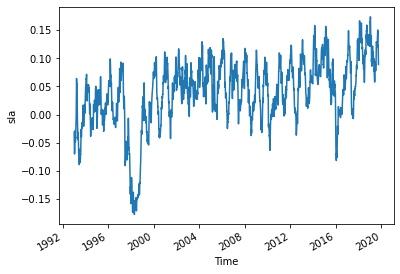

In [22]:
%%time
dir_pattern_zarr = 'F:/data/sat_data/aviso/zarr2/'
ds_zarr = xr.open_zarr(dir_pattern_zarr, consolidated=True)
ts = ds_zarr.sla.sel(latitude=slice(-10,0),longitude=slice(170,180)).mean({'latitude','longitude'}).plot()

# test time to make area average time series using netCDF and zarr files

Wall time: 6.85 s


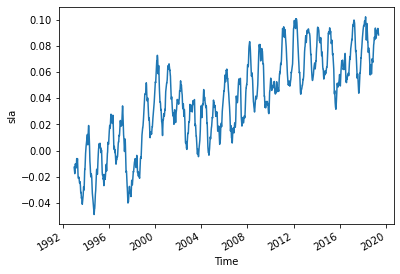

In [31]:
%%time
dir_pattern_zarr = 'F:/data/sat_data/aviso/zarr/'
ds_zarr = xr.open_zarr(dir_pattern_zarr)
ts = ds_zarr.sla.sel(latitude=slice(-50,0),longitude=slice(100,210)).mean({'latitude','longitude'}).plot()

Wall time: 10.1 s


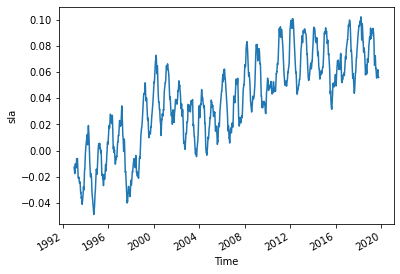

In [32]:
%%time
dir_pattern_zarr = 'F:/data/sat_data/aviso/zarr2/'
ds_zarr = xr.open_zarr(dir_pattern_zarr, consolidated=True)
ts = ds_zarr.sla.sel(latitude=slice(-50,0),longitude=slice(100,210)).mean({'latitude','longitude'}).plot()


In [11]:
#output data to zarr format
ds.to_zarr(dir_pattern_zarr, consolidated=True)